In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("task1_data.txt")
train_labels = pd.read_csv("task1_train_label.txt", header=None, sep="\t", names=["order", "label"])
valid_labels = pd.read_csv("task1_valid_label.txt", header=None, sep="\t", names=["order", "label"])
test_query = pd.read_csv("task1_test_query.txt",header=None, names=["order"])

In [3]:
train_df = df.merge(train_labels, on="order")
valid_df = df.merge(valid_labels, on="order")
test_df = df.merge(test_query, on="order")

In [4]:
# Order size correlate with label?
size_label = train_df.groupby("order").size().to_frame(name="count").merge(train_labels,on="order")
correlation = size_label['count'].corr(size_label['label'])


In [5]:
size_label.sort_values(by="count", ascending=False).head(500)

,order,count,label
293586,419483,46,2
470570,672813,44,1
94679,135161,39,1
296359,423492,39,1
26203,37473,38,1
...,...,...,...
431996,617753,21,1
367778,525911,21,1
431304,616751,21,1
93675,133775,21,1


In [6]:
corr = train_df.corr()
corr

,order,product,customer,color,size,group,label
order,1.000000,-0.000561,-0.001507,0.001061,-0.001926,0.000250,0.002247
product,-0.000561,1.000000,-0.000267,0.005640,-0.008649,-0.003215,-0.000678
customer,-0.001507,-0.000267,1.000000,-0.001716,0.001741,0.000054,0.000192
color,0.001061,0.005640,-0.001716,1.000000,0.002162,-0.017047,-0.001024
size,-0.001926,-0.008649,0.001741,0.002162,1.000000,0.033946,-0.008863
group,0.000250,-0.003215,0.000054,-0.017047,0.033946,1.000000,0.001111
label,0.002247,-0.000678,0.000192,-0.001024,-0.008863,0.001111,1.000000


<Axes: >

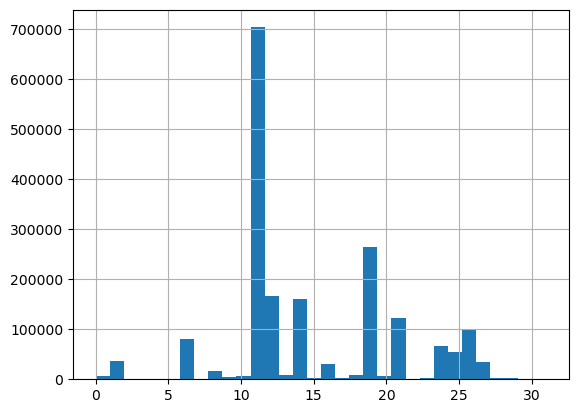

In [7]:
train_df["group"].hist(bins=train_df["group"].nunique())

In [8]:
train_df[train_df["order"] == 11376]

,order,product,customer,color,size,group,label
1734921,11376,37139,219886,436,24,11,1
1734922,11376,17792,219886,436,14,11,1
1734923,11376,50365,219886,516,24,11,1
1734924,11376,43120,219886,516,14,11,1
1734925,11376,7034,219886,302,24,11,1
1734926,11376,30801,219886,302,14,11,1
1734927,11376,1556,219886,40,24,11,1
1734928,11376,44539,219886,577,24,19,1
1734929,11376,51884,219886,302,14,6,1
1734930,11376,42052,219886,607,24,6,1


# Create customer stats
Return rates go up when ordering different size (and group) than usual

In [9]:
train_order_customer = train_df.groupby('order')['customer'].first().reset_index()


In [10]:
s = ["group", "customer"]
print("_"+"_".join(s)+"_stat")

_group_customer_stat


In [11]:
def create_user_stat_dist(df, group_by_cols, agg_col, agg_func):
    suff = "_"+"_".join(group_by_cols) + "_stat"
    agg_col_stat = agg_col + suff
    
    customer_stat =  df.groupby(group_by_cols).agg({agg_col: agg_func})
    merged_df = df.merge(customer_stat, on=group_by_cols, suffixes=("",suff))
    
    # If multiple modes exist they are stored as a list -> handle them differently
    filter_single_mode = merged_df[merged_df[agg_col_stat].apply(lambda x: isinstance(x, np.int64))]
    filter_multi_mode = merged_df[merged_df[agg_col_stat].apply(lambda x: not isinstance(x, np.int64))]
    
    
    label_dist_single_mode = filter_single_mode[filter_single_mode[agg_col] != filter_single_mode[agg_col_stat]][["order", "label"]].drop_duplicates()["label"].value_counts()
    label_dist_multi_mode = filter_multi_mode[filter_multi_mode.apply(lambda x: x[agg_col] not in x[agg_col_stat], axis=1)][["order", "label"]].drop_duplicates()["label"].value_counts()
    
    label_dist = label_dist_single_mode + label_dist_multi_mode
    label_dist = label_dist/label_dist.sum()
    return label_dist


In [12]:
group_difference_label_dist = create_user_stat_dist(train_df, ["customer"], "group", lambda x: pd.Series.mode(x))
size_difference_label_dist = create_user_stat_dist(train_df, ["customer", "group"], "size", lambda x: pd.Series.mode(x))

In [13]:
label_dist =  train_df[["order", "label"]].drop_duplicates()["label"].value_counts()
label_dist = label_dist/label_dist.sum()

<Axes: >

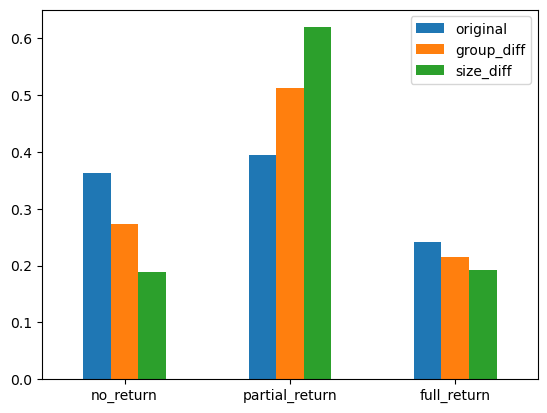

In [14]:
dist_df = pd.DataFrame({"original": label_dist, "group_diff": group_difference_label_dist, "size_diff": size_difference_label_dist})
dist_df.index = ['no_return', 'partial_return', 'full_return']
dist_df.plot(kind="bar", rot=0)

In [15]:
size_difference_label_dist

1    0.619636
2    0.192118
0    0.188246
Name: label, dtype: float64

In [16]:
def create_user_stat(df, group_by_cols, agg_col, agg_func):
    suff = "_"+"_".join(group_by_cols) + "_stat"
    agg_col_stat = agg_col + suff
    
    customer_stat =  df.groupby(group_by_cols).agg({agg_col: agg_func})
    merged_df = df.merge(customer_stat, on=group_by_cols, suffixes=("",suff))
    return merged_df

usual_user_size_by_group = train_df.groupby(['customer', 'group']).agg({"size": lambda x: pd.Series.mode(x)})

In [17]:
usual_user_size_by_group

size
customer group          
1        6             1
         11            1
         14            1
         16            1
         19            1
...                  ...
342031   24           10
342033   11           14
342035   12      [6, 21]
342037   11           24
         14     [14, 17]

[700646 rows x 1 columns]

In [18]:
train_df = train_df.merge(usual_user_size_by_group, on=['customer', 'group'], suffixes=("","_customer_group_stat"))
train_df["size_diff"] = train_df["size"] - train_df["size_customer_group_stat"]

filter_single_mode = train_df[train_df["size_diff"].apply(lambda x: isinstance(x, np.int64))]
filter_multi_mode = train_df[train_df["size_diff"].apply(lambda x: not isinstance(x, np.int64))]

filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))

train_df.update(filter_multi_mode)

/tmp/ipykernel_3905675/3427169022.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_multi_mode["size_diff"] = filter_multi_mode["size_diff"].apply(lambda x: min(abs(x)))


In [29]:
train_df.columns

Index(['order', 'product', 'customer', 'color', 'size', 'group', 'label',
       'size_customer_group_stat', 'size_diff'],
      dtype='object')

In [34]:
train_df["size_diff"] = train_df["size_diff"].astype(int)

In [35]:
train_df.corr()

/tmp/ipykernel_3905675/1233823885.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df.corr()


,order,product,customer,color,size,group,label,size_diff
order,1.000000,-0.000561,-0.001507,0.001061,-0.001926,0.000250,0.002247,0.000693
product,-0.000561,1.000000,-0.000267,0.005640,-0.008649,-0.003215,-0.000678,-0.003323
customer,-0.001507,-0.000267,1.000000,-0.001716,0.001741,0.000054,0.000192,-0.002571
color,0.001061,0.005640,-0.001716,1.000000,0.002162,-0.017047,-0.001024,0.003750
size,-0.001926,-0.008649,0.001741,0.002162,1.000000,0.033946,-0.008863,0.299232
group,0.000250,-0.003215,0.000054,-0.017047,0.033946,1.000000,0.001111,-0.012643
label,0.002247,-0.000678,0.000192,-0.001024,-0.008863,0.001111,1.000000,0.002159
size_diff,0.000693,-0.003323,-0.002571,0.003750,0.299232,-0.012643,0.002159,1.000000
